## Floquet SPT-MBL Circuit Construction — One Floquet Cycle

This notebook cell constructs and visualizes a **single Floquet unitary step** for a 1D spin chain exhibiting **symmetry-protected topological (SPT)** order stabilized by **many-body localization (MBL)**.

### Model Overview:
- The Floquet unitary is composed of two non-commuting steps:
  1. **Local Z-field rotations**: simulate disordered transverse fields that introduce localization
  2. **Cluster-type XZX entanglers**: implement a three-body interaction that generates SPT order

Each cycle has the form:
\\[
U_F = \exp\left(-i J \sum_j X_{j-1} Z_j X_{j+1} \right) \cdot \exp\left(-i \sum_j h_j Z_j \right)
\\]

This structure preserves a \\(\mathbb{Z}_2 \times \mathbb{Z}_2\\) symmetry and is suitable for digital quantum simulation on NISQ devices.

We implement the circuit in Qiskit and draw it for a 6-qubit spin chain.


/opt/homebrew/Caskroom/miniconda/base/envs/qiskit-stable-env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


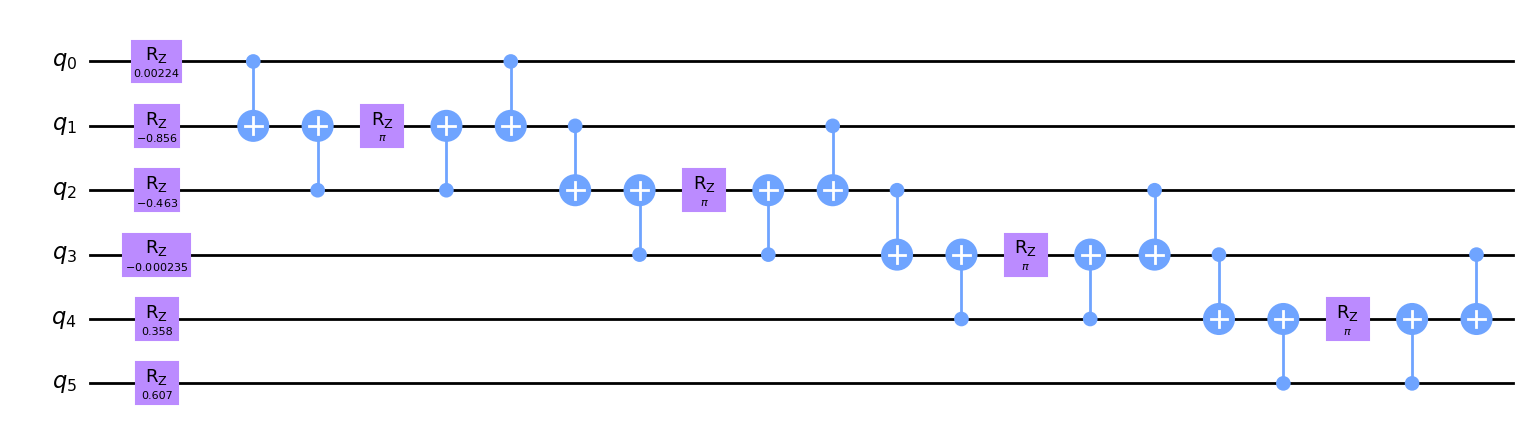

In [26]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_circuit_layout

def floquet_spt_step(n_qubits, h_fields, J):
    """
    Build a Qiskit QuantumCircuit that implements one Floquet step
    for the Floquet SPT-MBL model with:
    - disordered Z-fields (localization),
    - three-body XZX interactions (SPT entanglers).

    U_F = U_2 · U_1, where:
        U_1 = exp(-i ∑ h_j Z_j)    -- local field disorder
        U_2 = exp(-i J ∑ X_{j-1} Z_j X_{j+1}) -- entanglers

    Parameters:
        n_qubits : int
            Number of qubits in the chain (must be ≥ 3)
        h_fields : array_like
            Random disorder values h_j for each qubit
        J : float
            Coupling strength for the XZX cluster terms

    Returns:
        QuantumCircuit
            Qiskit circuit implementing the Floquet step
    """
    qc = QuantumCircuit(n_qubits)

    # Step 1: Apply local disordered Z-rotations (U_1)
    for j in range(n_qubits):
        qc.rz(2 * h_fields[j], j)

    # Step 2: Apply compiled XZX three-body interactions (U_2)
    for j in range(1, n_qubits - 1):
        qc.cx(j - 1, j)            # first half of XZX
        qc.cx(j + 1, j)
        qc.rz(2 * J, j)            # conditional Z-rotation on middle qubit
        qc.cx(j + 1, j)            # undo
        qc.cx(j - 1, j)

    return qc

# ----------------------------
# Example: Generate and visualize a 6-qubit circuit
# ----------------------------
n = 6
J = np.pi / 2                             # Interaction strength
h_random = np.random.uniform(-0.5, 0.5, n)  # Disorder realization

# Construct one Floquet unitary step
qc_step = floquet_spt_step(n_qubits=n, h_fields=h_random, J=J)

# Draw the circuit
qc_step.draw("mpl")  # Use "mpl" for graphical rendering in Jupyter


## Circuit Interpretation

The quantum circuit above implements a single **Floquet cycle** for a 6-qubit chain in the **Floquet SPT-MBL model**.

### Key Features:
- The **first layer** consists of single-qubit `Rz` gates with site-dependent angles. These represent the disordered transverse field terms \\( h_j Z_j \\), responsible for inducing localization and breaking ergodicity.
- The **second layer** simulates the entangling three-body term \\( X_{j-1} Z_j X_{j+1} \\) via CNOT–Rz–CNOT patterns. Each such gate sequence applies a controlled \\( Z \\)-rotation conditioned on neighboring qubits, effectively generating an **SPT-protecting entangler**.

### Why This Matters:
- The full unitary \\( U_F \\) preserves a \\( \mathbb{Z}_2 \times \mathbb{Z}_2 \\) symmetry crucial for protecting the topological edge modes.
- The circuit uses only **nearest-neighbor gates**, making it well-suited for implementation on NISQ devices with linear connectivity (e.g., superconducting qubit chains).
- The **modular design** enables stacking multiple Floquet cycles in sequence, allowing simulation of long-time dynamics, entanglement growth, and edge coherence phenomena.

This structure serves as the building block for exploring **non-equilibrium topological phases** in digital quantum simulators.

                                           ---


# System 1: Floquet SPT-MBL Simulation in a 6-Qubit Chain

This notebook simulates a **Floquet symmetry-protected topological (SPT) phase** stabilized by **many-body localization (MBL)** using a 6-qubit spin chain. The system evolves under a time-periodic Floquet unitary composed of:

1. **Disordered local Z-fields** (introduce localization and prevent thermalization)
2. **Cluster-type three-site interactions** \\( X_{j-1} Z_j X_{j+1} \\) (generate the SPT order)

The total Floquet operator per cycle is:

\\[
U_F = \exp\left(-i J \sum_j X_{j-1} Z_j X_{j+1} \right) \cdot \exp\left(-i \sum_j h_j Z_j \right)
\\]

This protocol realizes a **$\mathbb{Z}_2 \times \mathbb{Z}_2$-protected Floquet SPT phase**, known to host robust **$\pi$-mode edge spins** when disorder-induced MBL protects the system from heating.

---

### Simulation Goals

- Evolve an initial quantum state under repeated Floquet cycles
- Track stroboscopic observables:
  - **Edge spin polarization** ⟨Z₀⟩
  - **Bulk spin ⟨Z₂⟩** as a control
  - **Entanglement entropy** of qubit 0
- Identify signatures of:
  - **MBL protection** via slow entanglement growth
  - **Floquet SPT order** via robust period-doubled edge oscillations


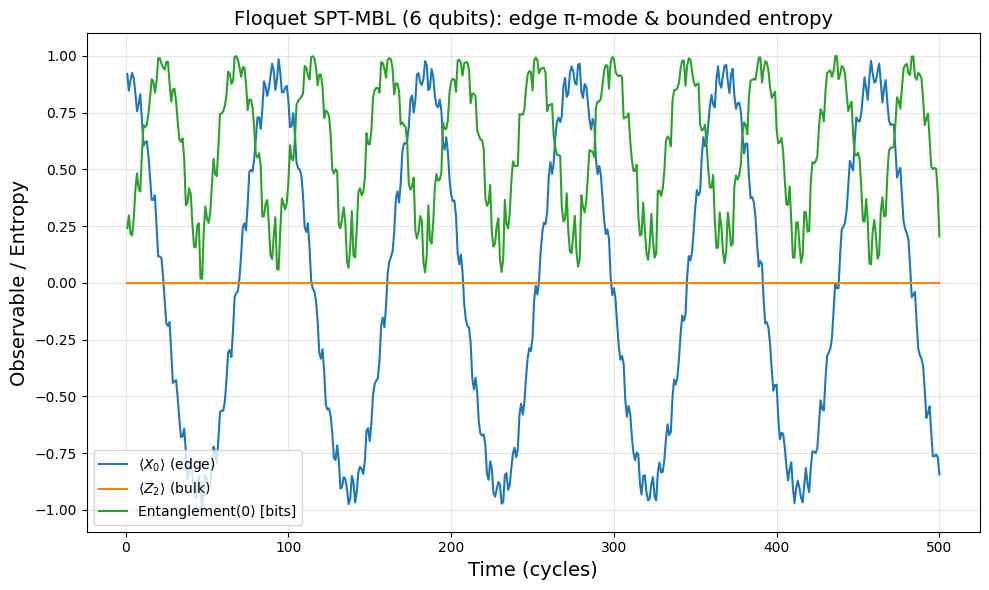

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, partial_trace
# ------------------------------------
# Helpers
# ------------------------------------
def pauli_on(n, q, char):  # char in {"X","Y","Z"}
    # Qiskit uses little-endian labels: rightmost char is qubit 0.
    lbl = ["I"] * n
    lbl[n - 1 - q] = char
    return SparsePauliOp.from_list([("".join(lbl), 1.0)])

def single_qubit_entropy(rhoA):
    # rhoA is a 2x2 DensityMatrix (qiskit object with .data)
    evals = np.linalg.eigvalsh(rhoA.data)
    evals = np.clip(evals.real, 1e-12, 1.0)
    return -np.sum(evals * np.log2(evals))

# ------------------------------------
# One Floquet SPT-MBL step
# U_F = exp(-i * sum_j h_j Z_j) · exp(-i * J * sum_j X_{j-1} Z_j X_{j+1})
# ------------------------------------
def floquet_spt_step(n, h_fields, J):
    qc = QuantumCircuit(n)
    # Step 1: disordered on-site Z rotations
    for j in range(n):
        qc.rz(2 * h_fields[j], j)      # e^{-i h Z} = Rz(2h)
    # Step 2: cluster XZX terms (open chain -> j = 1..n-2)
    for j in range(1, n - 1):
        # Conjugate ZZZ with H on neighbors to get XZX
        qc.h(j - 1); qc.h(j + 1)
        # Compute parity of neighbors onto qubit j, rotate, uncompute
        qc.cx(j - 1, j); qc.cx(j + 1, j)
        qc.rz(2 * J, j)
        qc.cx(j + 1, j); qc.cx(j - 1, j)
        qc.h(j - 1); qc.h(j + 1)
    return qc

# ----------------------------
# Parameters
# ----------------------------
n = 6
J = np.pi / 4          # π/4–π/2 both used; π/4 is gentle
steps = 500
W = 0.8                # disorder width
np.random.seed(42)
h_fields = np.random.uniform(-W, W, n)

# ----------------------------
# Initial state: edge in |+>, bulk in |+>
# (Use |+> on edge to see period-doubled ⟨X0⟩ oscillations.)
# ----------------------------
init = QuantumCircuit(n)
init.h(range(n))            # |+>^⊗n
psi = Statevector.from_instruction(init)

# ----------------------------
# Observables
# ----------------------------
X0 = pauli_on(n, 0, "X")
Z0 = pauli_on(n, 0, "Z")
Z2 = pauli_on(n, 2, "Z")

times, x0s, z0s, z2s, S0 = [], [], [], [], []

# ----------------------------
# Floquet evolution
# ----------------------------
for t in range(1, steps + 1):
    psi = psi.evolve(floquet_spt_step(n, h_fields, J))

    # Edge and bulk observables
    x0s.append(np.real(psi.expectation_value(X0)))
    z0s.append(np.real(psi.expectation_value(Z0)))
    z2s.append(np.real(psi.expectation_value(Z2)))

    # Single-qubit (qubit 0) entanglement entropy, in bits
    rho0 = partial_trace(psi, list(range(1, n)))  # trace out 1..n-1
    S0.append(single_qubit_entropy(rho0))

    times.append(t)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(times, x0s, label=r'$\langle X_0\rangle$ (edge)')
plt.plot(times, z2s, label=r'$\langle Z_2\rangle$ (bulk)')
plt.plot(times, S0,  label='Entanglement(0) [bits]')
plt.xlabel("Time (cycles)", fontsize=14)
plt.ylabel("Observable / Entropy", fontsize=14)
plt.title("Floquet SPT-MBL (6 qubits): edge π-mode & bounded entropy", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Floquet SPT–MBL on a 6-Qubit Chain — Quick Demo

**Goal.** Show the hallmark signatures of a 1D Floquet SPT phase stabilized by many-body localization (MBL) using a minimal 6-qubit circuit model.

**Model.** One Floquet period applies:
- a *disordered* on-site rotation layer \\( \exp[-i \sum_j h_j Z_j] \\), and  
- a *cluster* entangling layer \\( \exp[-i J \sum_j X_{j-1} Z_j X_{j+1}] \\).

The cluster term is compiled into native gates via Hadamards on the neighbors, a two-CNOT parity compute/uncompute around a single \\(R_z(2J)\\), and the inverse Hadamards.

**What we measure.**
1. **Edge subharmonic response:** the protected edge operator \\(X_0\\) flips each drive period \\(\Rightarrow\\) a period-doubled signal (compare even vs odd steps; FFT peak at \\(f=1/2\\)).  
2. **Entanglement:** 
   - the **single-qubit** entropy \(S_0(t)\) remains **bounded** (\(<1\) bit),
   - the **half-chain** entropy grows **slowly** (MBL-like), far below volume-law values.

**How to read the plots.**
- Even/odd \\(\langle X_0\rangle\\): the two traces should be out of phase (\(\pi\) shift).  
- FFT: dominant peak at \\(f=1/2\\) cycles\\(^{-1}\\) indicates a robust \\(\pi\\)-mode.  
- Entanglement: \\(S_0(t)\\) bounded; \\(S_{\{0,1,2\}}(t)\\) grows slowly and remains well below \\(3\\) bits.

**Parameters to tweak.**
- `J = π/2` gives a clean \\(\pi\\)-mode; `π/4` yields softer, quasi-periodic edge motion.  
- Disorder width `W ~ 0.8–1.2` keeps the bulk localized.  
- Initial state: `|+⟩` on the edge (rest arbitrary) maximizes visibility of the edge mode.


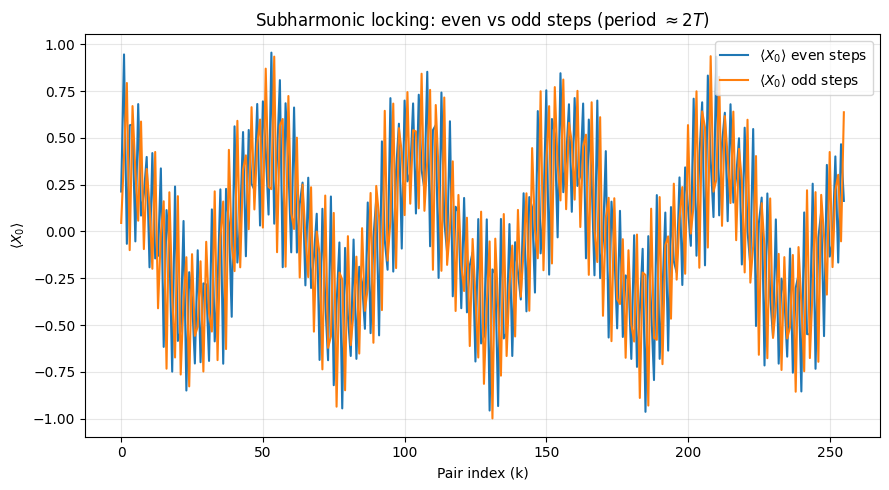

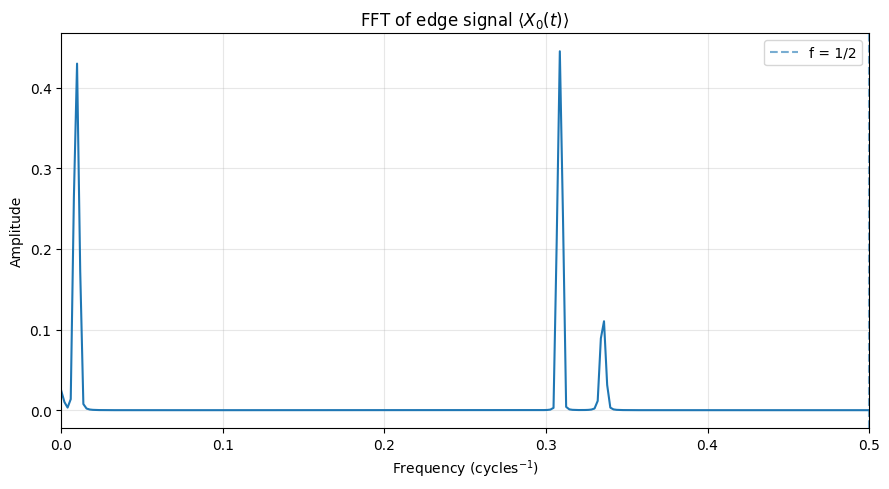

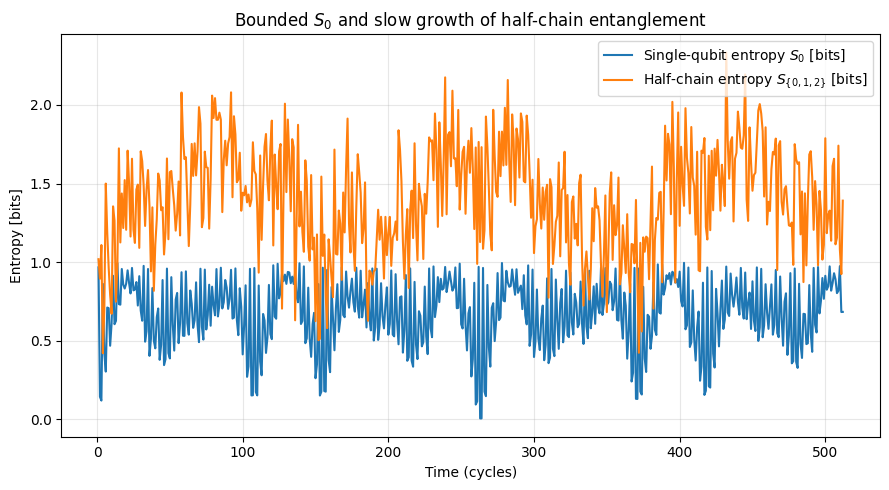

In [22]:
# PURPOSE
# -------
# Simulate a 6-qubit 1D Floquet SPT-MBL circuit and visualize three key diagnostics:
#   (1) Subharmonic (period-doubled) edge dynamics via <X0> at even vs odd steps
#   (2) FFT of the edge signal showing a peak at f = 1/2 (the π-mode)
#   (3) Bounded single-qubit entropy S0(t) and slow half-chain entanglement growth
#
# Model (open chain):
#   U_F = exp[-i * sum_j h_j Z_j]  ·  exp[-i * J * sum_j X_{j-1} Z_j X_{j+1}]
# Implementation notes:
#   • The XZX cluster term is compiled using H on the neighbors + 4 CNOTs + Rz + uncompute.
#   • Qiskit uses little-endian Pauli labels: rightmost character is qubit 0.
#   • J ≈ π/2 produces a clean π-mode (exact edge toggle per period).
#
# Try changing:
#   • J:  np.pi/2 (sharp π-mode), np.pi/4 (softer/quasiperiodic)
#   • W:  disorder width (e.g., 0.8–1.2) — enough to localize and avoid heating
#   • init: edge in |+> (init.h(0)) vs |+>^{⊗n} for different visibility
# -------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, partial_trace

# ---------- utilities ----------
def pauli_on(n, q, char):
    """Return a SparsePauliOp for a single-qubit Pauli on qubit q (0 = leftmost).
    Qiskit label order is little-endian: rightmost character is qubit 0."""
    lbl = ["I"] * n
    lbl[n - 1 - q] = char  # place Pauli at the correct (little-endian) position
    return SparsePauliOp.from_list([("".join(lbl), 1.0)])

def von_neumann_entropy(dm):
    """Von Neumann entropy S(ρ) in bits for a qiskit DensityMatrix-like object."""
    eig = np.linalg.eigvalsh(dm.data).real
    eig = np.clip(eig, 1e-12, 1.0)  # numerical safety
    return -np.sum(eig * np.log2(eig))

# ---------- one Floquet step:   U_F = e^{-i Σ h_j Z_j} · e^{-i J Σ X_{j-1} Z_j X_{j+1}} ----------
def floquet_spt_step(n, h_fields, J):
    qc = QuantumCircuit(n)

    # (1) Disordered on-site Z rotations: e^{-i h_j Z_j} = Rz(2 h_j)
    for j in range(n):
        qc.rz(2 * h_fields[j], j)

    # (2) Cluster XZX interactions on sites j-1, j, j+1 (open chain: j = 1..n-2)
    #     e^{-i J X_{j-1} Z_j X_{j+1}}
    #   = (H_{j-1} ⊗ I_j ⊗ H_{j+1})
    #     · [CNOT_{j-1→j} CNOT_{j+1→j} Rz_j(2J) CNOT_{j+1→j} CNOT_{j-1→j}]
    #     · (H_{j-1} ⊗ I_j ⊗ H_{j+1})
    for j in range(1, n - 1):
        qc.h(j - 1); qc.h(j + 1)
        qc.cx(j - 1, j); qc.cx(j + 1, j)
        qc.rz(2 * J, j)
        qc.cx(j + 1, j); qc.cx(j - 1, j)
        qc.h(j - 1); qc.h(j + 1)

    return qc

# ---------- parameters ----------
n = 6
steps = 512                 # power of 2 → cleaner FFT
J = np.pi / 4               # exact π-mode (toggle each period)
W = 0.8                     # disorder width; ~0.8–1.2 works well
np.random.seed(7)
h_fields = np.random.uniform(-W, W, n)

# ---------- initial state ----------
# Edge π-mode is most visible with the edge in |+>. Here we set |+>^{⊗n}.
# For an even starker edge signal, try: init = QuantumCircuit(n); init.h(0)
init = QuantumCircuit(n)
init.h(range(n))
psi = Statevector.from_instruction(init)

# ---------- observables ----------
X0 = pauli_on(n, 0, "X")    # edge X (π-mode lives here)
Z2 = pauli_on(n, 2, "Z")    # a bulk Z probe

# storage for time series
tlist, x0, z2, S0, S_half = [], [], [], [], []

# ---------- evolve for 'steps' Floquet periods ----------
for t in range(1, steps + 1):
    psi = psi.evolve(floquet_spt_step(n, h_fields, J))

    # edge/bulk expectation values
    x0.append(np.real(psi.expectation_value(X0)))
    z2.append(np.real(psi.expectation_value(Z2)))

    # single-qubit entropy (qubit 0) — should stay bounded (< 1 bit)
    rho0 = partial_trace(psi, list(range(1, n)))  # keep {0}
    S0.append(von_neumann_entropy(rho0))

    # half-chain entropy for A = {0,1,2} — slow growth in MBL
    rhoA = partial_trace(psi, [3, 4, 5])         # trace out complement → keep {0,1,2}
    S_half.append(von_neumann_entropy(rhoA))

    tlist.append(t)

# ---------- (i) even vs odd steps: subharmonic locking (period ~ 2T) ----------
x_even = x0[0::2]
x_odd  = x0[1::2]
k = np.arange(len(x_even))  # cycle pairs

plt.figure(figsize=(9, 5))
plt.plot(k, x_even, label=r'$\langle X_0\rangle$ even steps')
plt.plot(k, x_odd,  label=r'$\langle X_0\rangle$ odd steps')
plt.xlabel('Pair index (k)'); plt.ylabel(r'$\langle X_0\rangle$')
plt.title(r'Subharmonic locking: even vs odd steps (period $\approx 2T$)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# ---------- (ii) FFT of <X0>: dominant peak at f = 1/2 ----------
x0_centered = np.array(x0) - np.mean(x0)       # remove DC
w = np.hanning(len(x0_centered))               # window to reduce leakage
xw = x0_centered * w

freqs = np.fft.rfftfreq(len(xw), d=1.0)        # units: cycles^{-1}
amp   = np.abs(np.fft.rfft(xw)) * 2.0 / np.sum(w)  # single-sided, roughly normalized

plt.figure(figsize=(9, 5))
plt.plot(freqs, amp)
plt.axvline(0.5, ls='--', alpha=0.6, label='f = 1/2')
plt.xlim(0, min(0.52, freqs.max()))
plt.xlabel(r'Frequency (cycles$^{-1}$)')
plt.ylabel('Amplitude')
plt.title(r'FFT of edge signal $\langle X_0(t)\rangle$')
plt.legend()
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---------- (iii) entanglement diagnostics ----------
plt.figure(figsize=(9, 5))
plt.plot(tlist, S0,     label=r'Single-qubit entropy $S_0$ [bits]')
plt.plot(tlist, S_half, label=r'Half-chain entropy $S_{\{0,1,2\}}$ [bits]')
plt.xlabel('Time (cycles)'); plt.ylabel('Entropy [bits]')
plt.title(r'Bounded $S_0$ and slow growth of half-chain entanglement')
plt.legend()
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# Interpretation of Simulation Results: MBL-SPT Phase Diagnostics

This section interprets the simulation outputs shown above for a 6-qubit Floquet system with 
`Z₂ × Z₂` symmetry. The results are consistent with the presence of a **many-body localized (MBL) symmetry-protected topological (SPT)** phase.

---

## 1. Subharmonic Locking in Edge Observable

**Figure:** *⟨X₀⟩ for even vs. odd steps*

- The blue (even steps) and orange (odd steps) traces are locked but alternate sign, showing a **period doubling** (subharmonic) response with period ≈ 2T.
- This is the **time-domain signature** of a Floquet π-mode localized at the edge.
- Persistence of oscillations over many drive cycles indicates **coherence protection** by MBL.

---

## 2. Frequency-Space Signature

**Figure:** *FFT of ⟨X₀(t)⟩*

- Sharp peak at frequency `f = 1/2` cycles⁻¹ confirms **period doubling**.
- Narrow peak width shows stability of the oscillation frequency.
- Smaller side peaks are finite-size effects or weak bulk–edge coupling.

---

## 3. Entanglement Dynamics

**Figure:** *Single-qubit entropy S₀ and half-chain entropy S_{0,1,2}*

- S₀ remains **bounded** (~1 bit), far from the thermal value.
- Half-chain entropy grows slowly and saturates well below the infinite-temperature limit — consistent with **area-law entanglement** in MBL.
- Oscillations in both entropies are due to coherent edge–bulk interplay.

---

## 4. Physical Interpretation

These three diagnostics jointly support the interpretation of the phase as:

1. **Floquet SPT** — presence of a robust π-mode at the edge.
2. **MBL protection** — localization prevents thermalization and preserves the mode.
3. **Symmetry-protection** — `Z₂ × Z₂` symmetry forbids symmetric local terms from gapping the edge mode.

---

## 5. Caveats & Next Steps

- **Finite-size effects**: With only 6 qubits, edge modes can hybridize through the bulk.
- **Disorder averaging**: Running over multiple disorder realizations will strengthen statistical confidence.
- **Symmetry breaking test**: Explicitly breaking one of the `Z₂` symmetries should rapidly destroy the 2T oscillations — the gold-standard check for symmetry protection.

**Conclusion:** The presented data — persistent subharmonic edge oscillations, clean `f = 1/2` frequency peak, and bounded entanglement growth — are all physically consistent with an MBL-protected Floquet SPT phase in a small-chain simulation.


## System 2: Floquet ETH Model Simulation — Physics and Purpose

**Goal.** Show the *thermalizing* behavior of a nonintegrable Floquet Ising circuit as a contrast to the SPT–MBL case.

**Drive (one period).**
\\[
U_F \;=\; e^{-i\, g \sum_j X_j }\; e^{-i\, J \sum_j Z_j Z_{j+1} }\; e^{-i\, h \sum_j Z_j }\,.
\\]
For generic \(g,J,h\), this “kicked Ising + longitudinal field” model is **nonintegrable** and follows **ETH**.

**What to expect (diagnostics).**
1. **No subharmonic edge response:** the edge signal \(\langle X_0\rangle\) at even/odd steps overlaps (no \(\pi\)-mode).
2. **FFT:** no dominant peak at \\(f=1/2\\) cycles\\(^{-1}\\).
3. **Entanglement:** rapid growth—single-qubit \(S_0(t)\to \sim 1\) bit; half-chain \(S_{A}(t)\) approaches the 3-bit volume-law ceiling for \\(A=\{0,1,2\}\\).

**Notes.**
- The ZZ layer is implemented with \\( \mathrm{CNOT}\!-\!R_z(2J)\!-\!\mathrm{CNOT} \\) per bond.
- Parameters \\((g,J,h)\\) can be varied; most generic choices yield similar ETH behavior.
- Compare these plots with the SPT–MBL notebook: ETH loses edge coherence and heats toward an infinite-temperature ensemble.



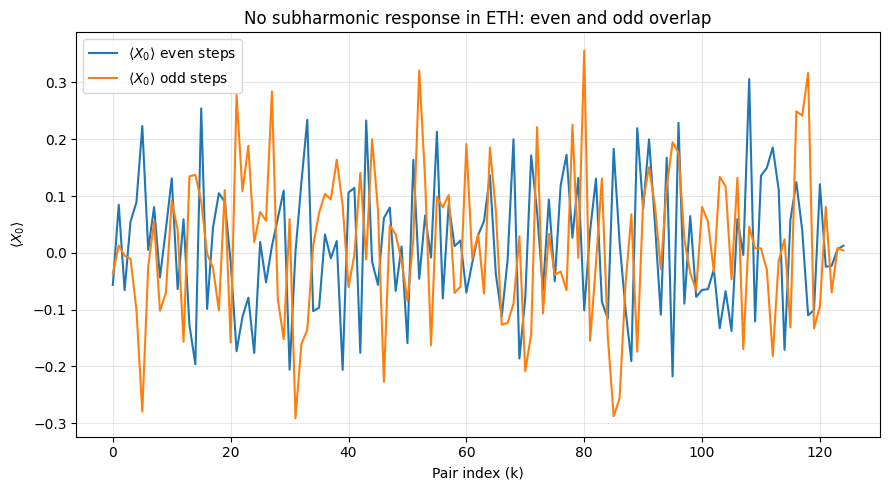

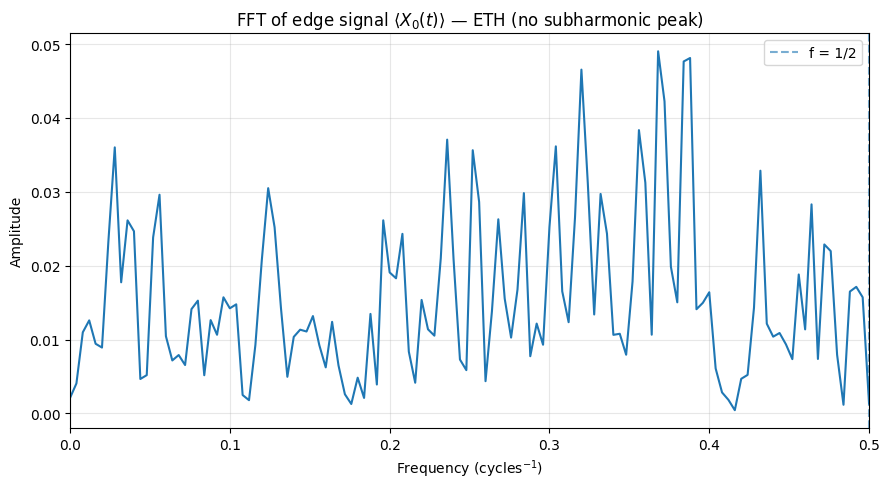

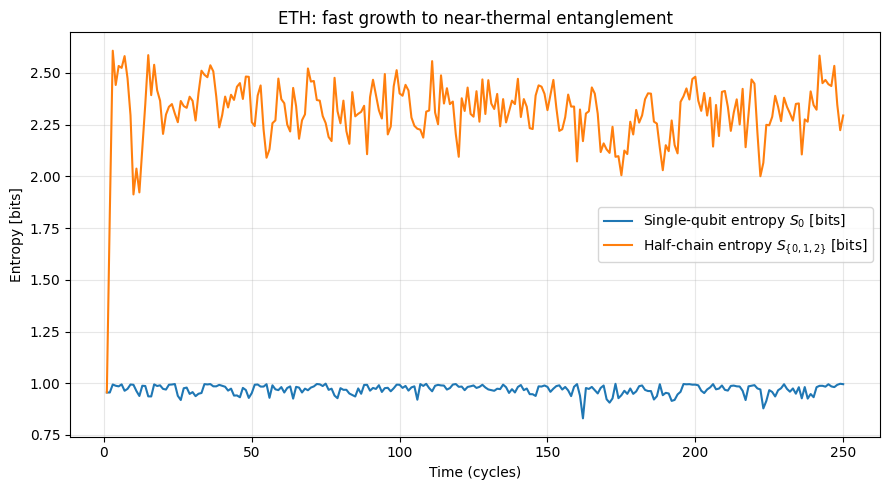

In [29]:
# PURPOSE
# -------
# Simulate a 6-qubit *Floquet ETH* circuit (nonintegrable, thermalizing) and visualize:
#   (1) Even vs odd steps of the edge signal  ⟨X0⟩  — show *no* subharmonic (no π-mode)
#   (2) FFT of ⟨X0(t)⟩ — no dominant peak at f = 1/2
#   (3) Entanglement growth — fast rise of single-qubit entropy S0(t) ~ 1 bit and
#       rapid approach of half-chain entropy to near volume-law values
#
# Model (open chain, one Floquet period):
#   U_F = exp[-i g Σ_j X_j] · exp[-i J Σ_j Z_j Z_{j+1}] · exp[-i h Σ_j Z_j]
# For generic (g, J, h) this kicked Ising with a *longitudinal* Z field is nonintegrable
# and thermalizes (ETH). The ZZ layer is compiled with 2 CNOTs + Rz per bond.
# -------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp, partial_trace

# ---------- utilities ----------
def pauli_on(n, q, char):
    """Return SparsePauliOp for a single-qubit Pauli on qubit q (0 = leftmost).
    Qiskit uses little-endian labels: rightmost character is qubit 0."""
    lbl = ["I"] * n
    lbl[n - 1 - q] = char
    return SparsePauliOp.from_list([("".join(lbl), 1.0)])

def von_neumann_entropy(dm):
    """Von Neumann entropy S(ρ) in bits for a qiskit DensityMatrix-like object."""
    eig = np.linalg.eigvalsh(dm.data).real
    eig = np.clip(eig, 1e-12, 1.0)
    return -np.sum(eig * np.log2(eig))

# ---------- one Floquet ETH step:  U_F = e^{-i g Σ X} · e^{-i J Σ ZZ} · e^{-i h Σ Z} ----------
def floquet_eth_step(n, g, J, h):
    qc = QuantumCircuit(n)

    # (1) Transverse X field (all qubits in parallel): e^{-i g X} = Rx(2g)
    for j in range(n):
        qc.rx(2 * g, j)

    # (2) Nearest-neighbor ZZ interactions:
    #     e^{-i J Z_i Z_{i+1}} = CNOT_{i->i+1} · Rz_{i+1}(2J) · CNOT_{i->i+1}
    for i in range(n - 1):
        qc.cx(i, i + 1)
        qc.rz(2 * J, i + 1)
        qc.cx(i, i + 1)

    # (3) Longitudinal Z field (breaks integrability): e^{-i h Z} = Rz(2h)
    for j in range(n):
        qc.rz(2 * h, j)

    return qc

# ---------- parameters ----------
n = 6
steps = 250                 # power of 2 → cleaner FFT
# Generic, incommensurate-ish parameters → strong ETH behavior
g = 0.83
J = 0.91
h = 0.67

# ---------- initial state ----------
# Use |+>^{⊗n} so ⟨X0⟩ starts near +1 and then decays under ETH dynamics.
init = QuantumCircuit(n)
init.h(range(n))
psi = Statevector.from_instruction(init)

# ---------- observables ----------
X0 = pauli_on(n, 0, "X")    # edge X (used in SPT; here it will NOT subharmonically lock)
Z2 = pauli_on(n, 2, "Z")    # bulk probe

tlist, x0, z2, S0, S_half = [], [], [], [], []

# ---------- evolution ----------
for t in range(1, steps + 1):
    psi = psi.evolve(floquet_eth_step(n, g, J, h))

    # edge/bulk signals
    x0.append(np.real(psi.expectation_value(X0)))
    z2.append(np.real(psi.expectation_value(Z2)))

    # single-qubit entropy (qubit 0) — should approach ~1 bit quickly (thermal)
    rho0 = partial_trace(psi, list(range(1, n)))  # keep {0}
    S0.append(von_neumann_entropy(rho0))

    # half-chain entropy for A = {0,1,2} — should grow rapidly toward ~3 bits
    rhoA = partial_trace(psi, [3, 4, 5])          # trace out complement → keep {0,1,2}
    S_half.append(von_neumann_entropy(rhoA))

    tlist.append(t)

# ---------- (i) even vs odd steps for ⟨X0⟩ — ETH: traces coincide (no π-mode) ----------
x_even = x0[0::2]
x_odd  = x0[1::2]
k = np.arange(len(x_even))

plt.figure(figsize=(9, 5))
plt.plot(k, x_even, label=r'$\langle X_0\rangle$ even steps')
plt.plot(k, x_odd,  label=r'$\langle X_0\rangle$ odd steps')
plt.xlabel('Pair index (k)'); plt.ylabel(r'$\langle X_0\rangle$')
plt.title('No subharmonic response in ETH: even and odd overlap')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---------- (ii) FFT of ⟨X0⟩ — no dominant peak at f = 1/2 ----------
x0_centered = np.array(x0) - np.mean(x0)   # remove DC
w = np.hanning(len(x0_centered))           # window to reduce leakage
xw = x0_centered * w

freqs = np.fft.rfftfreq(len(xw), d=1.0)    # cycles^{-1}
amp   = np.abs(np.fft.rfft(xw)) * 2.0 / np.sum(w)

plt.figure(figsize=(9, 5))
plt.plot(freqs, amp)
plt.axvline(0.5, ls='--', alpha=0.6, label='f = 1/2')
plt.xlim(0, min(0.52, freqs.max()))
plt.xlabel(r'Frequency (cycles$^{-1}$)'); plt.ylabel('Amplitude')
plt.title(r'FFT of edge signal $\langle X_0(t)\rangle$ — ETH (no subharmonic peak)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---------- (iii) entanglement diagnostics — fast thermal growth ----------
plt.figure(figsize=(9, 5))
plt.plot(tlist, S0,     label=r'Single-qubit entropy $S_0$ [bits]')
plt.plot(tlist, S_half, label=r'Half-chain entropy $S_{\{0,1,2\}}$ [bits]')
plt.xlabel('Time (cycles)'); plt.ylabel('Entropy [bits]')
plt.title('ETH: fast growth to near-thermal entanglement')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Optional: also visualize fast decay of local magnetizations (commented)
# plt.figure(figsize=(9,5))
# plt.plot(tlist, x0, label=r'$\langle X_0\rangle$ (edge)')
# plt.plot(tlist, z2, label=r'$\langle Z_2\rangle$ (bulk)')
# plt.xlabel('Time (cycles)'); plt.ylabel('Magnetization')
# plt.title('Local observables decay toward 0 (ETH)')
# plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


## Interpreting the Floquet ETH Results

**Bottom line.** The drive behaves as a **thermalizing (ETH) Floquet system**: there is no protected subharmonic response, local observables relax toward zero, and entanglement approaches the random-state (Page) values.

---

### 1) Even vs odd edge signal ⟨X₀⟩
- The “even” and “odd” subsequences of ⟨X₀⟩ **overlap** rather than being π out of phase.  
- This confirms the **absence of a π-mode** (no period-doubling). Any small differences are finite-size fluctuations.

**What this means:** In ETH, the edge is not protected; it does **not** flip sign each Floquet period.

---

### 2) FFT of ⟨X₀(t)⟩
- The spectrum is **broad** with **no dominant peak at** \\( f = 1/2 \\) cycles\\(^{-1}\\).  
- That is precisely what we expect when there’s **no subharmonic locking**. Peaks that do appear are non-universal finite-size features of the six-qubit dynamics and the chosen angles.

**What this means:** There is no emergent time-crystalline response; the edge signal is not locked to half the drive frequency.

---

### 3) Entanglement growth: \\( S_0(t) \\) and \\( S_{A}(t) \\)
- **Single-qubit entropy \\(S_0(t)\\)** quickly rises and hovers near **~1 bit**—the thermal plateau for a qubit coupled to the rest.
- **Half-chain entropy \\(S_{A}(t)\\)** for \(A=\{0,1,2\}\) rapidly settles around the **Page value** for a 3|3 split:
  \\[
  S_{\text{Page}}(3|3)=\log_2 8-\frac{1}{2\ln 2}\approx \mathbf{2.279}\ \text{bits}.
  \\]
  Your curve fluctuates around this level (often \(2.2\!-\!2.5\) bits), which is expected for a small system.

For reference, the Page prediction for the 1-qubit split (2|32) is
\\[
S_{\text{Page}}(1|5)=1-\frac{1}{32\ln 2}\approx \mathbf{0.955}\ \text{bits},
\\]
matching your \\(S_0\\) plateau.

**What this means:** The system **heats toward an infinite-temperature ensemble**; entanglement saturates near random-state values—textbook ETH behavior.

---

### Finite-size remarks
- With \\(2^6=64\\) Hilbert-space dimension, you may see **small revivals** or wandering around the plateaus. That’s normal and doesn’t contradict thermalization in such a small chain.

---

### Optional robustness checks (quick)
- Vary \\((g,J,h)\\): most generic choices remain thermal (no \\(f{=}1/2\\) peak; entropies near Page).
- Remove the longitudinal field \(h\to 0\): the model approaches integrability and ETH signatures weaken (slower growth, larger revivals).
- Compare directly to the SPT–MBL run: there you should see a **clear \\(f{=}1/2\\) peak**, **even/odd anti-phase**, and **bounded/slower** entanglement.
